# Dueling DQN on Pedulum_v1
参考[《动手学强化学习》第8章](https://hrl.boyuai.com/chapter/2/dqn%E6%94%B9%E8%BF%9B%E7%AE%97%E6%B3%95)

In [1]:
import random
import numpy as np
import collections
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym

# Q网络

<img src="./picture8_1.png" alt="插入图片哈哈" width="50%">
红色表示状态值，蓝色表示该状态下每个动作的优势值
<br>网络结构画的是cartpole,环境用的pendulum


<img src="./picture8_2.png" alt="插入图片哈哈" width="80%">

In [2]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
class VAnet(torch.nn.Module):
    ''' 只有一层隐藏层的A网络和V网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)    # 共享网络部分
        self.fc_A = torch.nn.Linear(hidden_dim, action_dim)  # 这个状态有几个动作，优势值就有几个
        self.fc_V = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        A = self.fc_A(h)
        V = self.fc_V(h)
        # A = self.fc_A(F.relu(self.fc1(x)))
        # V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)
        return Q

In [3]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), np.array(action), reward, np.array(next_state), done

    def size(self):
        return len(self.buffer)

In [4]:
class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,state_dim,hidden_dim,action_dim,learning_rate,gamma,epsilon,target_update,device,dqn_type='VanillaDQN'):

        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
        else:
            self.q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,self.action_dim).to(device)

        self.optimizer = torch.optim.Adam(self.q_net.parameters(),lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def max_q_value(self, state):
        state = torch.tensor(np.array([state]), dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'].reshape(-1, 1) ,dtype=torch.long).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)
        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1

In [5]:
def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]      # 连续动作的最小值，获得环境的动作的界限
    action_upbound = env.action_space.high[0]      # 连续动作的最大值
    return action_lowbound + (discrete_action /(action_dim - 1)) * (action_upbound -action_lowbound)

# 训练

In [6]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0

    for i in range(10):
        with tqdm(total=int(num_episodes / 10),desc='Iteration %d' % i) as pbar:

            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state , info = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)

                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env,agent.action_dim)
                    # action对应动作索引0-10，agent.action_dim=11
                    # 要把这个动作的索引转成实际的值，传进去比如第0个动作就是-2，第1个动作是-1.6。

                    next_state, reward, terminated, truncated, info = env.step(np.array([action_continuous]))
                    done = terminated or truncated
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {'states': b_s,'actions': b_a,'next_states': b_ns,
                                           'rewards': b_r,'dones': b_d }
                        agent.update(transition_dict)
                return_list.append(episode_return)

                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),'return':'%.3f' % np.mean(return_list[-10:])})
                pbar.update(1)
    return return_list, max_q_value_list

In [7]:
buffer_size = 50000
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
hidden_dim = 128
action_dim = 11  # 将连续动作分成11个离散动作
lr = 1e-3
gamma = 0.99
epsilon = 0.03
target_update = 50
device = torch.device("cuda:0")
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,target_update, device, 'DuelingDQN')

## 开始训练

In [8]:
num_episodes=500
minimal_size = 3000
batch_size = 64
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,replay_buffer, minimal_size,batch_size)

Iteration 9: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s, episode=500, return=-181.224]


## 训练结束

### 保存网络

In [9]:
torch.save(agent.q_net.state_dict(), 'dueling_dqn_pendulum_q_net.pth')

### 训练过程可视化

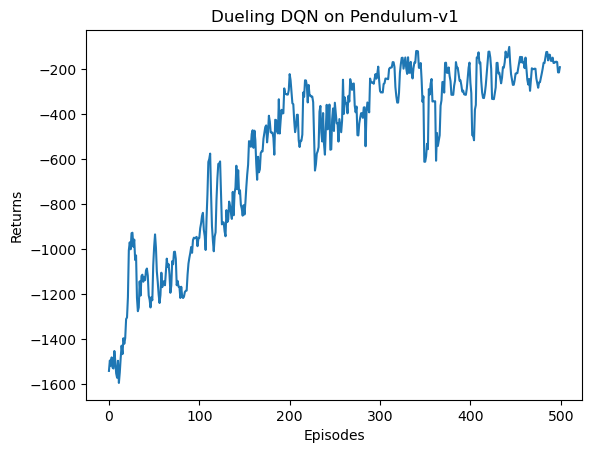

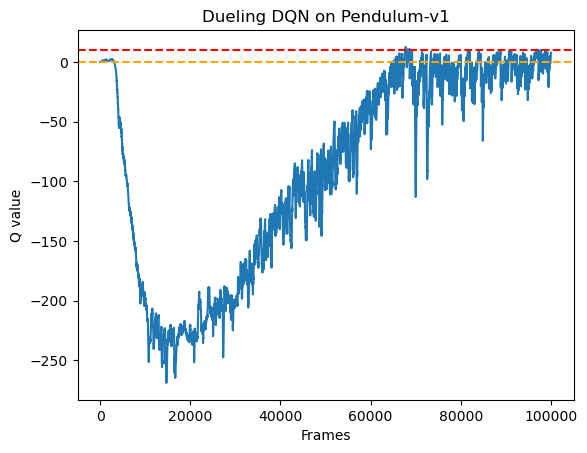

In [10]:
def moving_average(x, window):
    x = np.array(x, dtype=float)
    ma = np.zeros_like(x)  # 存放结果
    for i in range(len(x)):
        start = max(0, i - window + 1)
        end = i + 1
        ma[i] = x[start:end].mean()   # 只用窗口内现有元素求平均
    return ma
episodes_list = list(range(len(return_list)))
mv_return = moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Dueling DQN on {}'.format(env_name))
plt.show()

普通DQN是把state传进q_net,把next_state传进target_q_net,会得到每个动作的q值，直接取最大的q值，q_targets = rewards + gamma * max_next_q_value
(直接取最大的q值，不代表下一步会选这个动作，而Sarsa在这个你取的哪个动作的q值，你下一步行动就是哪个动作)
Double-DQN是next_state传入q_net，得到使得q最大的动作，然后再把next_states传入target_q_net,得到q,但不是直接选最大的q,而是根据刚刚得到的动作，选择那个动作对应的q。
Dueling-DQN是在更新时跟普通DQN一样，区别在于网络，输出得到q的方法不一样。